# Q1 :
# implement an algorithm based on LSTM to forecast the price of Gold.

### Set Train Data between 1st Jan 2017 to 31st October 2017 and Test Data between 1st Nov 2017 to 31st December 2017.

In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [2]:
# Loading the data
df = pd.read_excel('Q1 Data Gold Price  .xlsx')

In [3]:
df.head()

,Month,Day Name,Date,Gold Price,Sold Volume (Kg.)
0,January,Sunday,2017-01-01,2013,694
1,January,Monday,2017-01-02,2260,680
2,January,Tuesday,2017-01-03,2137,662
3,January,Wednesday,2017-01-04,2235,831
4,January,Thursday,2017-01-05,2137,624


In [4]:
# Chekcing null values
df.isnull().sum()

Month                0
Day Name             0
Date                 0
Gold Price           0
Sold Volume (Kg.)    0
dtype: int64

### No null values found

In [5]:
# Considering only Gold price and Date coulmn for LSTM implemenation

df = df[['Date', 'Gold Price']]
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df.head()

,Gold Price
Date,
2017-01-01,2013
2017-01-02,2260
2017-01-03,2137
2017-01-04,2235
2017-01-05,2137


<AxesSubplot:xlabel='Date'>

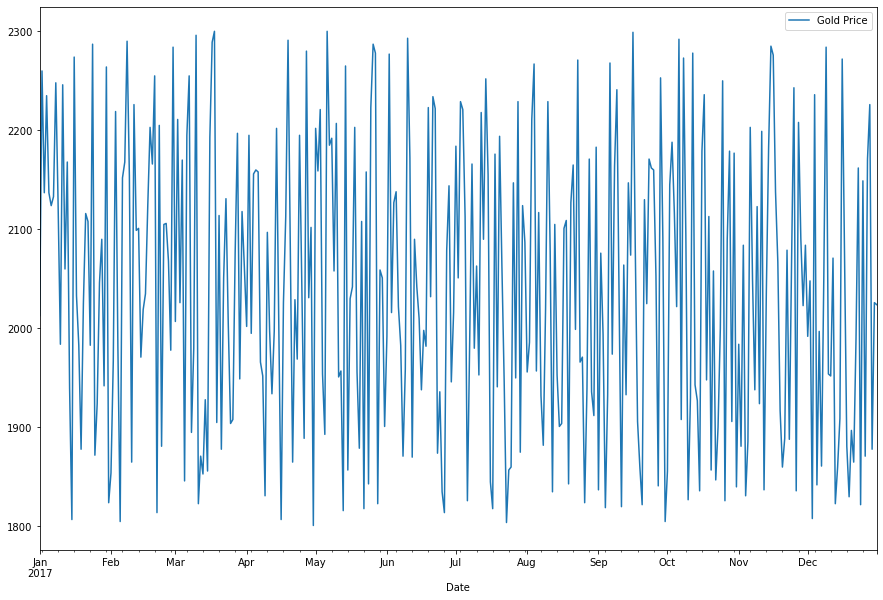

In [6]:
# Plotting to see the gold price variations
df.plot(figsize=(15,10))

In [7]:
df.describe()

,Gold Price
count,365.000000
mean,2041.356164
std,143.425285
min,1801.000000
25%,1924.000000
50%,2036.000000
75%,2162.000000
max,2300.000000


# Splitting data from before 1st Nov as train and after 1st Nov as Test

In [8]:
# Splitting data from before 1st Nov as train and after 1st Nov as Test
split_date = pd.Timestamp('11-01-2017')

In [9]:
train = df.loc[:split_date, ['Gold Price']]
test = df.loc[split_date:, ['Gold Price']]

In [10]:
train.shape, test.shape

((305, 1), (61, 1))

In [11]:
test.head() # Contains data post Nov'17

,Gold Price
Date,
2017-11-01,1984
2017-11-02,1881
2017-11-03,2084
2017-11-04,1831
2017-11-05,1886


In [17]:
# Normalizing the train data
sc = MinMaxScaler(feature_range= (0,1))
train_scaled = sc.fit_transform(train)

In [25]:
test_scaled = sc.fit_transform(test)

In [19]:
train_scaled.shape

(305, 1)

In [15]:
'''# Creating a data structure with 5 time-steps and 1 output

x_train = []
y_train = []
for i in range(5, 305):
    x_train.append(training_set_scaled[i-5:i,0])
    y_train.append(training_set_scaled[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))''' Manual method of creating sequence

In [15]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [20]:
# Creating a data structure with 5 time-steps and 1 output
seq_size = 5  ## number of steps (lookback)
n_features = 1 ## number of features. This dataset is univariate so it is 1
train_generator = TimeseriesGenerator(train_scaled, train_scaled, length = seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(train)) # 305
print("Total number of samples in the generated data = ", len(train_generator)) # 300 with seq_size=5

Total number of samples in the original training data =  305
Total number of samples in the generated data =  300


In [22]:
#Check data shape from generator
x,y = train_generator[10]  #Check train_generator
#Takes 5 days as x and 6th day as y (for seq_size=7)

In [23]:
x.shape, y.shape

((1, 5, 1), (1, 1))

In [26]:
#Also generate test data
test_generator = TimeseriesGenerator(test_scaled, test_scaled, length=seq_size, batch_size=1)
print("Total number of samples in the original training data = ", len(test)) # 14 as we're using last 14 days for test
print("Total number of samples in the generated data = ", len(test_generator)) # 7
#Check data shape from generator
x,y = test_generator[0]

Total number of samples in the original training data =  61
Total number of samples in the generated data =  56


In [30]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

#Define Model 
model = Sequential()
model.add(LSTM(150, activation='relu', return_sequences=True, input_shape=(seq_size, n_features)))
model.add(LSTM(64, activation='relu'))
model.add(Dense(64))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 150)            91200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                55040     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 150,465
Trainable params: 150,465
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(train_generator, 
                              validation_data=test_generator, 
                              epochs=10, batch_size = 32)

Epoch 1/10
300/300 [==============================] - 4s 4ms/step - loss: 0.1270 - val_loss: 0.0937
Epoch 2/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0847 - val_loss: 0.0950
Epoch 3/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0797 - val_loss: 0.0980
Epoch 4/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0845 - val_loss: 0.0918
Epoch 5/10
300/300 [==============================] - 3s 10ms/step - loss: 0.0884 - val_loss: 0.0923
Epoch 6/10
300/300 [==============================] - 2s 5ms/step - loss: 0.0918 - val_loss: 0.1086
Epoch 7/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0862 - val_loss: 0.1034
Epoch 8/10
300/300 [==============================] - 1s 3ms/step - loss: 0.0792 - val_loss: 0.0952
Epoch 9/10
300/300 [==============================] - 1s 4ms/step - loss: 0.0825 - val_loss: 0.0914
Epoch 10/10
300/300 [==============================] - 1s 5ms/step - loss: 0.0819 - val_loss: 0.096

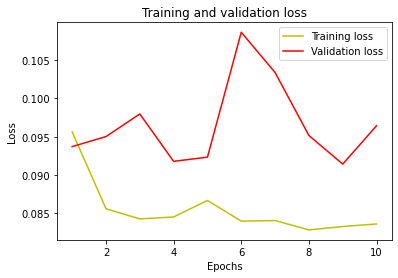

In [32]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [40]:
predicted = model.predict(test_generator)

In [41]:
predicted[2]

array([0.5229165], dtype=float32)

In [44]:
### Inverse transform to before scaling so we get actual numbers
rescaled_prediction = sc.inverse_transform(predicted)

In [45]:
rescaled_prediction[2]

array([2057.4312], dtype=float32)

In [59]:
rescaled_prediction.shape

(56, 1)

In [74]:
test1 = test[5:]

In [75]:
test1.shape

(56, 1)

In [88]:
time_series_array = test1.index

In [89]:
rescaled_prediction1 = pd.DataFrame(rescaled_prediction, index=time_series_array)

In [90]:
rescaled_prediction1

,0
Date,
2017-11-06,2060.892334
2017-11-07,2060.267578
2017-11-08,2057.431152
2017-11-09,2059.530518
2017-11-10,2056.025635
2017-11-11,2054.577881
2017-11-12,2055.420410
2017-11-13,2056.192871
2017-11-14,2055.409912


In [79]:
print(type(test1)), print(type(rescaled_prediction))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


(None, None)

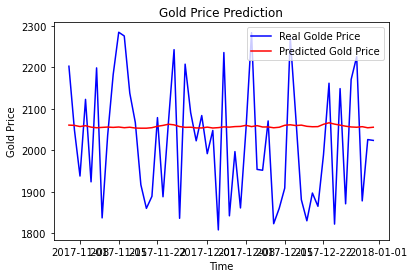

In [91]:
# Visualising the results
#plt.figure(figsize=(14,5))
plt.plot(test1, color = 'blue', label = 'Real Golde Price')
plt.plot(rescaled_prediction1, color = 'red', label = 'Predicted Gold Price')
plt.title('Gold Price Prediction')
plt.xlabel('Time')
plt.ylabel('Gold Price')
plt.legend()
plt.show()